# Project 2 - Time Series Forecasting

### forecasting - Air travel passangers data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams

# fixing the graph fig size
rcParams['figure.figsize'] = 15, 6

In [2]:
# loading dataset
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# dataset column's datatype
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [4]:
# converting the Month data into the datetime format
# using the dateparse function - dateparse('1962-01')
from datetime import datetime as dt
dateparse = lambda dates: dt.strptime(dates, '%Y-%m')

# loading the dataset once more with the dateparse and also making the month column as index
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
# Check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [6]:
# since the Month column is now the index, there is only one data column left
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [7]:
# convert to time series
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

##### Example for index and values

In [8]:
ts['1949-05-01']

121

## Checking for Stationarity

### Plotting the time-series

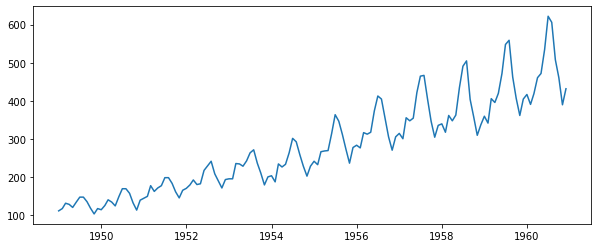

In [9]:
plt.figure(figsize=(10,4))
plt.plot(ts)

In [46]:
# for Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# Checking for stationarity 

# Creating function for stationarity test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # printing out the tuple generated
    print(dftest,"\n")
    
    # ordered print of dftest
    dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput1)
    
    print("\n----------------------------------------------\n")
    
    dfoutput2 = pd.Series(dtype=float)
    for key,value in dftest[4].items():
        dfoutput2['Critical Value (%s)'%key] = value
    print(dfoutput2)
    

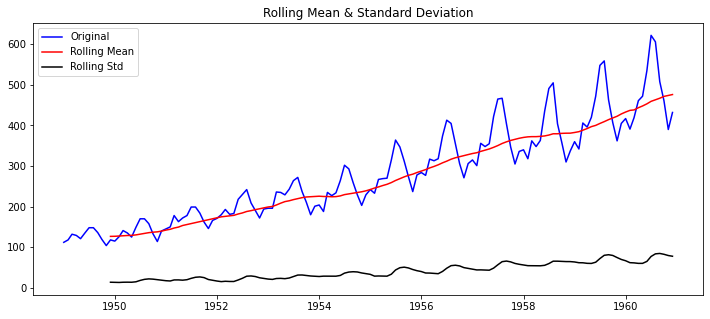

Results of Dickey-Fuller Test:
(0.8153688792060497, 0.991880243437641, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019) 

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64

----------------------------------------------

Critical Value (1%)    -3.481682
Critical Value (5%)    -2.884042
Critical Value (10%)   -2.578770
dtype: float64


In [47]:
# Deploying the function
test_stationarity(ts)

##### Conclusion: Since the rolling mean and rolling standard deviation is not constant, keeps increasing steadily with time, there is no stationarity in the data

## Making the Time Series Stationary
### Estimating and Eliminating Trends

In [61]:
# taking the log value of the dataset and then ploting it
ts_log = np.log(ts)

# comparing example log value with the original value
print(ts.head(2), "\n--------------------------------\n", ts_log.head(2))


Month
1949-01-01    112
1949-02-01    118
Name: #Passengers, dtype: int64 
--------------------------------
 Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: #Passengers, dtype: float64


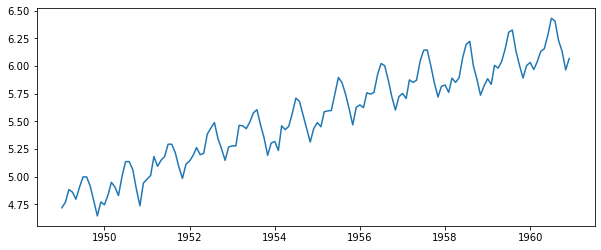

In [62]:
# plotting with the log values

plt.figure(figsize=(10,4))
plt.plot(ts_log)

# Notice the y-axis values are considerably smaller 

## Smoothing:
### Moving average

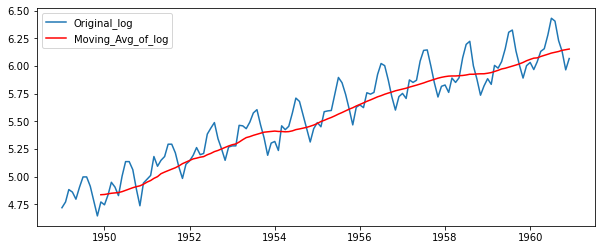

In [64]:
moving_avg = ts_log.rolling(window=12).mean()

plt.figure(figsize=(10,4))
plt.plot(ts_log, label='Original_log')
plt.plot(moving_avg, color='red', label='Moving_Avg_of_log')
plt.legend(loc="best")

#### Average is still not constant, it is still in increasing trend, even after smoothing

In [65]:
# Now getting the differnce between the log values and the moving_avg value to get much more depreciated values

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

In [67]:
# dropping all the invalid values, since there will be some missing values in the list due to fact 
# that we depricated the mean values with the original instances of the values from 
# which the mean was calculated.

ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

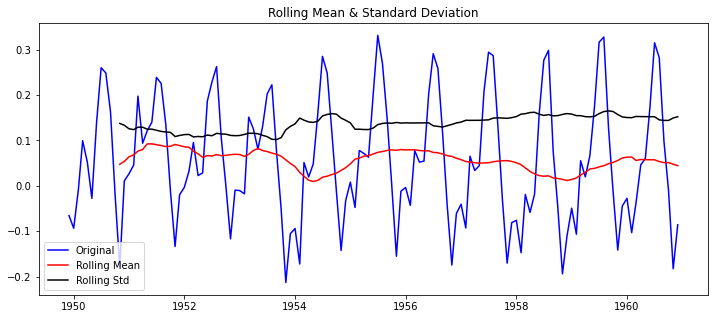

Results of Dickey-Fuller Test:
(-3.1629079913008664, 0.022234630001243285, 13, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, -436.63269481747125) 

Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
dtype: float64

----------------------------------------------

Critical Value (1%)    -3.486535
Critical Value (5%)    -2.886151
Critical Value (10%)   -2.579896
dtype: float64


In [68]:
# Now testing for stationarity with the new dataset

test_stationarity(ts_log_moving_avg_diff)

#### compared to the previous p-value here it is very small, previously it was almost 0.991 and now it is 0.022, so the mean and standard deviation are going to be close to z constant trend as we can see that in the above graph.

### Exponentially Weighted Moving Average

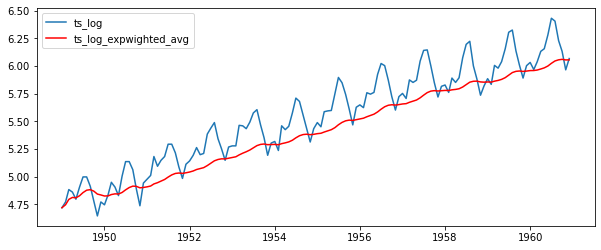

In [69]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.figure(figsize=(10,4))
plt.plot(ts_log, label="ts_log")
plt.plot(expwighted_avg, color='red', label="ts_log_expwighted_avg")
plt.legend(loc="best")

# expwighted_avg.plot(style='k--')

#df.ewm(com=0.5).mean()

In [71]:
# comparing ts_log value with the ewm_avg values
print(expwighted_avg.head(), "\n--------------------------------\n", ts_log.head())

# Very slight differnce between the two

Month
1949-01-01    4.718499
1949-02-01    4.745345
1949-03-01    4.793835
1949-04-01    4.811785
1949-05-01    4.808206
Name: #Passengers, dtype: float64 
--------------------------------
 Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64


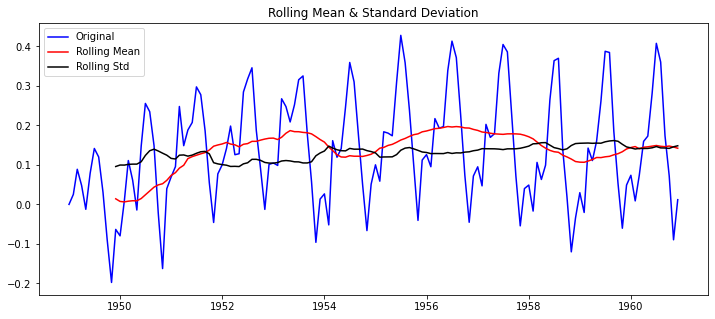

Results of Dickey-Fuller Test:
(-3.601262420161678, 0.005736938801511859, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, -462.8241632483198) 

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64

----------------------------------------------

Critical Value (1%)    -3.481682
Critical Value (5%)    -2.884042
Critical Value (10%)   -2.578770
dtype: float64


In [73]:
# Now taking the difference between the above values and checking for stationarity

ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

##### The p-value is further decreased and the mean and std deviation is merging in places to provide a better constant trend, but still there are some fluctuations.

## Eliminating Trend and Seasonality

### Differencing:

In [77]:
# comparing ts_log value with the ts_log.shift() values
print(ts_log.head(), "\n--------------------------------\n", ts_log.shift().head())

#just shifting one value to the right

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64 
--------------------------------
 Month
1949-01-01         NaN
1949-02-01    4.718499
1949-03-01    4.770685
1949-04-01    4.882802
1949-05-01    4.859812
Name: #Passengers, dtype: float64


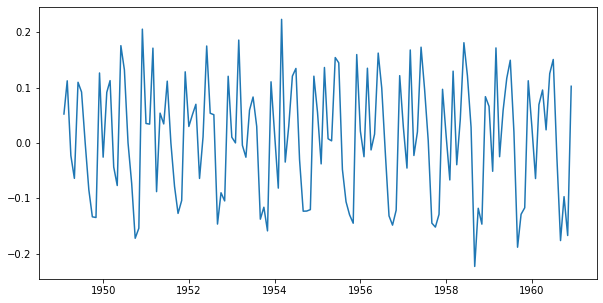

In [75]:
# Take first difference:
ts_log_diff = ts_log - ts_log.shift()

plt.figure(figsize=(10,5))
plt.plot(ts_log_diff)

##### This is absolutely trendless but can achieve constant mean and std deviation

##### Now here checking for stationarity

<Figure size 864x432 with 0 Axes>

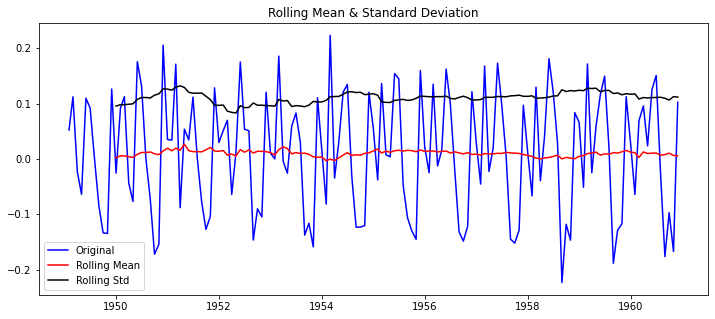

Results of Dickey-Fuller Test:
(-2.7171305983881453, 0.07112054815085667, 14, 128, {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}, -440.35846985568105) 

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
dtype: float64

----------------------------------------------

Critical Value (1%)    -3.482501
Critical Value (5%)    -2.884398
Critical Value (10%)   -2.578960
dtype: float64


In [78]:
ts_log_diff.dropna(inplace=True)

plt.figure(figsize=(12,6))
test_stationarity(ts_log_diff)

##### The graph shows a steady mean and std deviation line but the p-value has increased slightly in this case

### Decomposition:

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

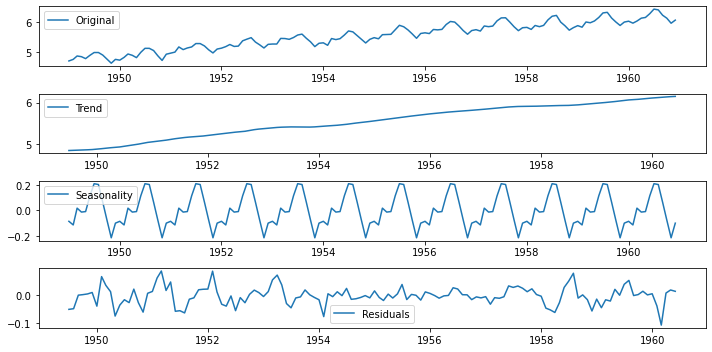

In [84]:
# Visually comparing the original, trend, seasonal, residual errors in the dataset

plt.figure(figsize=(10,5))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

<Figure size 864x360 with 0 Axes>

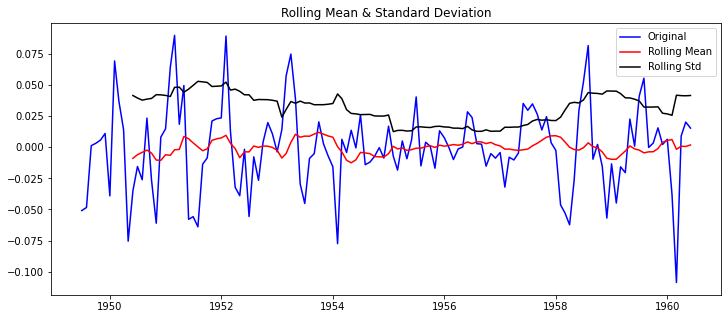

Results of Dickey-Fuller Test:
(-6.332386797644905, 2.8850589033227534e-08, 9, 122, {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}, -517.2642969403792) 

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
dtype: float64

----------------------------------------------

Critical Value (1%)    -3.485122
Critical Value (5%)    -2.885538
Critical Value (10%)   -2.579569
dtype: float64


In [86]:
# taking residual data and then checking for stationarity

plt.figure(figsize=(12,5))

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose)

##### Residual data is providing the worst trends and stationarity plot, the p-value is very high in this case, suggesting to eleminate the residual data from the original one to get a constant trend.

## Final Forecasting

In [88]:
# Forecasting using the ARIMA model 
# ARIMA - Auto Regressive (AR) Integrated (I) Moving Average (MA) 

# three different methods combined to form ARIMA model

from statsmodels.tsa.arima_model import ARIMA

##### To check which method to use from ARIMA - (AR), (I), (MA), we need to get the ACF and PACF values

##### If the ACF value is good then we can only use AR model
##### If PACF value is better then we may use only MA model 
##### If no correlation is comming up then go for Integrated (I) model

## ACF & PACF Plots

C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


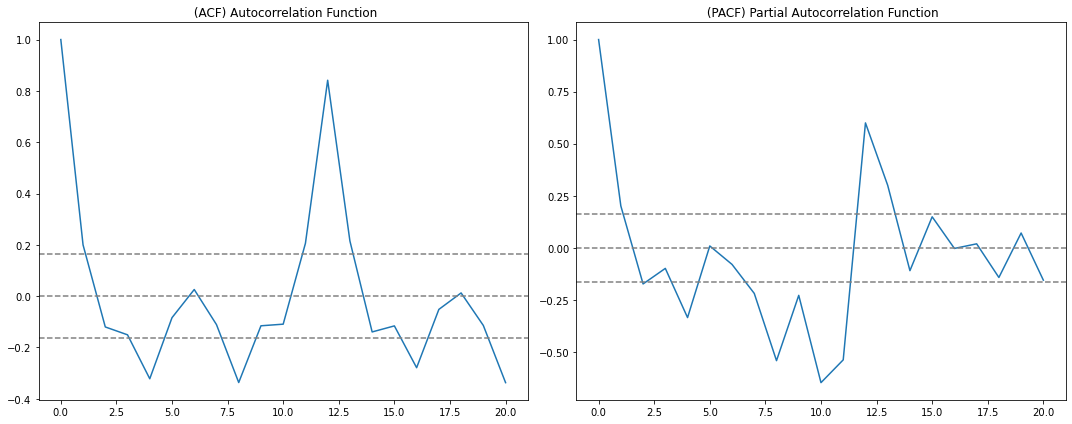

In [98]:
# ACF  - Auto Correlation Factor 
# PACF - Partial Auto Correlation Factor

from statsmodels.tsa.stattools import acf, pacf

lag_acf  = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:  
#plt.figure(figsize=(10,5))
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title(' (ACF) Autocorrelation Function')

#Plot PACF:
#plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title(' (PACF) Partial Autocorrelation Function')

plt.tight_layout()

##### We have to use the Integrated model since th ACF and PACF both are showing similar features

## Testing each model Separately for comaprison

### AR Mode :

C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

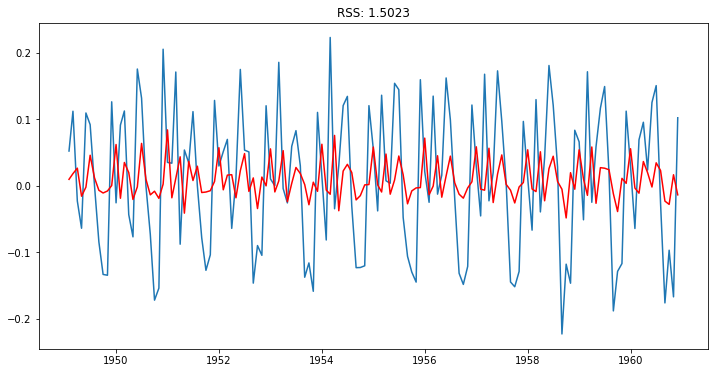

In [100]:
# order=(AR, I, MV) -- (2, 1, 0) means highest priority to AR model and then integrate and ignore MV model here
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.figure(figsize=(12,6))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

##### Red is the predicted and blue is the actual data, so only a few points where able to be predicted and mapped correctly here and the residual value is 1.5

### MA Model :

C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

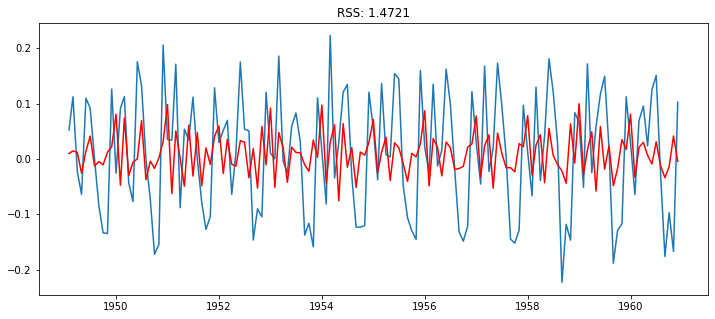

In [101]:
# order=(AR, I, MV) -- (0, 1, 2) means highest priority to MA model and then integrate and ignore AR model here
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(12,5))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

##### here also red is the predicted and blue is the actual data, so only a few points where able to be predicted and mapped correctly here and the residual value is 1.4

### Now Doing the Integrated ARIMA Model

#### ARIMA Model :

C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Joy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

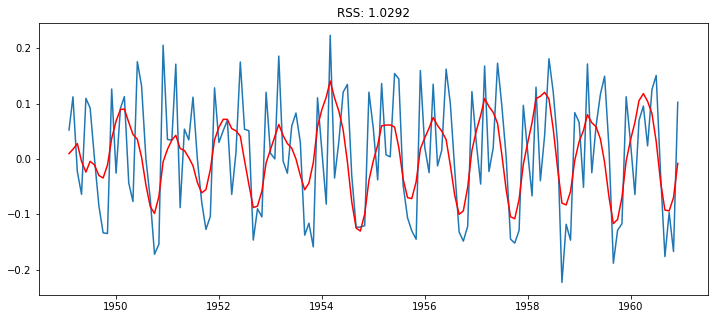

In [102]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  

plt.figure(figsize=(12,5))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

#####  here we can see that the model is predicting aslmost accurately to the original data and the residual value is also decreased to 1.0 so its very minimum compared to the other two model values, so it concludes that the Intergrated ARIMA model is the best predictive model for this time series model.

### Convert to original scale:

In [103]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [104]:
# cumulative additive (cascade addition) dataset

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [105]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

In [106]:
# comparing predicted log value with the original log values
print(predictions_ARIMA_log.head(10), "\n--------------------------------\n", ts_log.head(10))

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
1949-06-01    4.744830
1949-07-01    4.740483
1949-08-01    4.729506
1949-09-01    4.699577
1949-10-01    4.665110
dtype: float64 
--------------------------------
 Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
1949-07-01    4.997212
1949-08-01    4.997212
1949-09-01    4.912655
1949-10-01    4.779123
Name: #Passengers, dtype: float64


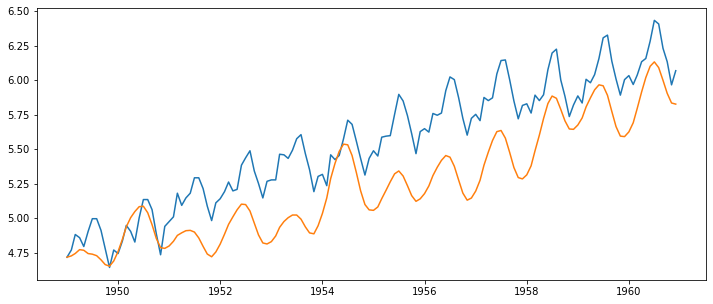

In [107]:
# Visual reference for the prediction of log values
plt.figure(figsize=(12,5))
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 90.1041')

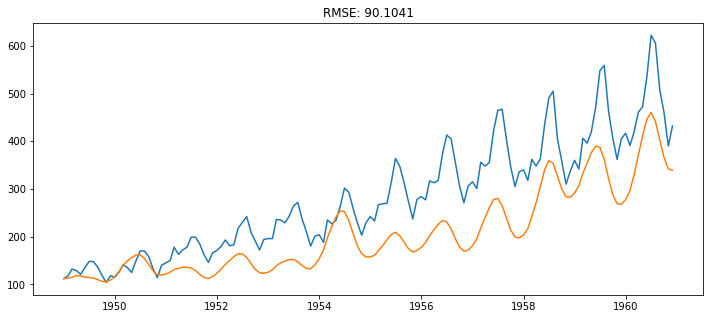

In [108]:
# Visual reference for the prediction of original values

predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.figure(figsize=(12,5))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [110]:
# comparing predicted value with the original values
print(predictions_ARIMA.head(10), "\n--------------------------------\n", data.head(10))

Month
1949-01-01    112.000000
1949-02-01    113.078123
1949-03-01    115.073417
1949-04-01    118.301992
1949-05-01    117.768369
1949-06-01    114.988280
1949-07-01    114.489528
1949-08-01    113.239586
1949-09-01    109.900663
1949-10-01    106.177221
dtype: float64 
--------------------------------
             #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
1949-06-01          135
1949-07-01          148
1949-08-01          148
1949-09-01          136
1949-10-01          119


## Future Possible Data Predictions

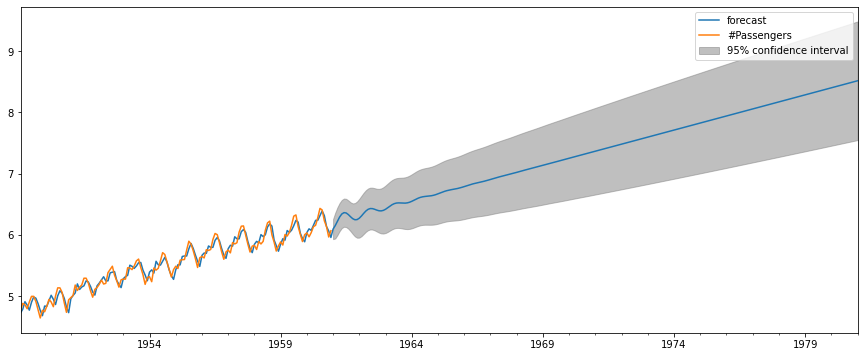

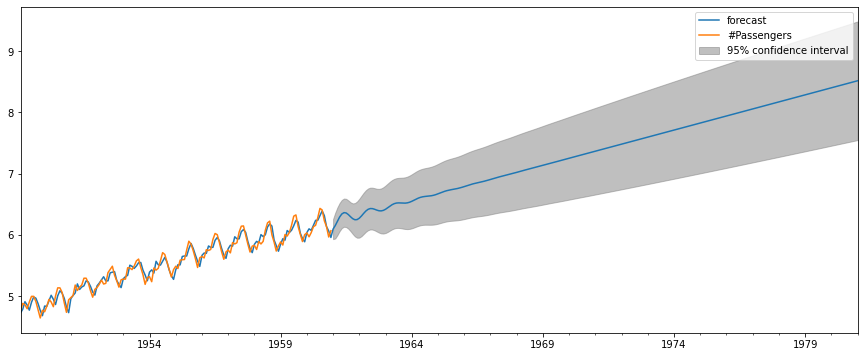

In [112]:
results_ARIMA.plot_predict(1,384)

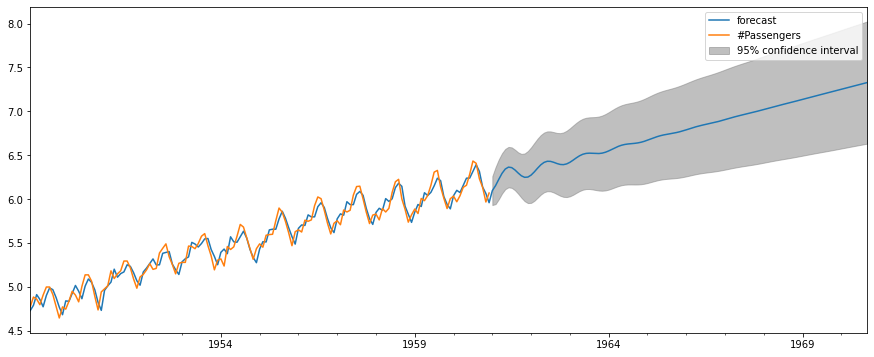

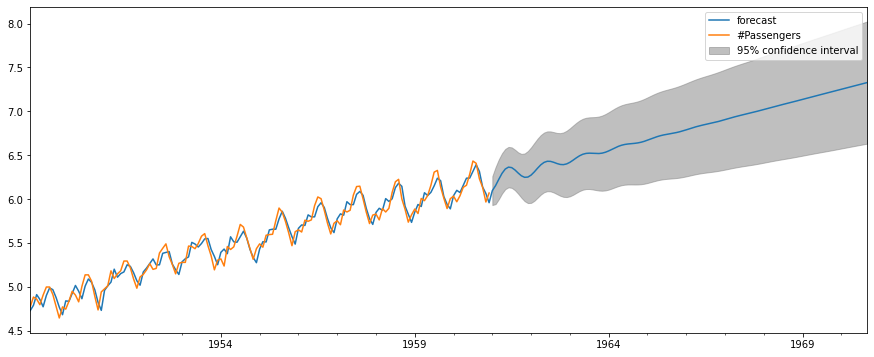

In [119]:
results_ARIMA.plot_predict(1,260)

In [115]:
x=results_ARIMA.forecast(steps=156)
x

(array([6.09553403, 6.15281421, 6.22442987, 6.2924112 , 6.34164729,
        6.36359365, 6.35784682, 6.33139296, 6.29597533, 6.26447712,
        6.24738332, 6.25025187, 6.27275859, 6.30940339, 6.3515152 ,
        6.38988678, 6.41727398, 6.43011064, 6.42906694, 6.41842492,
        6.40456161, 6.39403627, 6.39183101, 6.40019528, 6.41833723,
        6.44295441, 6.46937468, 6.49294015, 6.51024143, 6.51989053,
        6.52267596, 6.52112404, 6.51864546, 6.51853713, 6.52311952,
        6.53322395, 6.54812907, 6.56591597, 6.58410347, 6.60036576,
        6.61313299, 6.62192811, 6.62737818, 6.63093158, 6.63438721,
        6.6393802 , 6.64696544, 6.65739884, 6.6701537 , 6.68414297,
        6.69806672, 6.71077945, 6.72157774, 6.73034025, 6.73749851,
        6.7438642 , 6.75037366, 6.75782639, 6.76668731, 6.77699875,
        6.78841372, 6.80032907, 6.81207248, 6.82308813, 6.83307188,
        6.84202544, 6.85022364, 6.85811274, 6.86617395, 6.87479208,
        6.88416361, 6.89426444, 6.90487951, 6.91